In [31]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "utils")))
from analysis_utils import volcano_plot_br, plot_spatial_clusters_per_sample, plot_dotplot_by_treatment
import scanpy as sc
import numpy as np

import scanpy as sc
import matplotlib.pyplot as plt

pig_genes = purple_genes = [
    "Apoe", "Arpc1b", "Axl", "B2m", "C1qa", "C1qb", "C1qc", "C4b",
    "Cd63", "Cd9", "Clu", "Csf1r", "Cst3", "Ctsa", "Ctsb", "Ctsd",
    "Ctsh", "Ctsl", "Ctss", "Ctsz", "Cx3cr1", "Cyba", "Fcer1g", "Fcgr3",
    "Fcrls", "Gfap", "Gns", "Grn", "Gusb", "H2-D1", "H2-K1", "Hexa",
    "Hexb", "Igfbp5", "Itgb5", "Itm2b", "Laptm5", "Lgals3bp", "Lgmn", "Ly86",
    "Lyz2", "Man2b1", "Mpeg1", "Npc2", "Olfml3", "Plek", "Prdx6",
    "S100a6", "Serpina3n", "Trem2", "Tyrobp", "Vsir"
]
olig_genes = [
    "Plp1", "Mbp", "Mobp", "Cnp", "Cldn11", "Mal", "Apod", "Trf", "Fth1", "Plekhb1", "Ppp1r14a", "Ttyh2", "Fa2h", "Aspa"
]
modules = {
    "PIG": pig_genes,
    "OLIG": olig_genes
}

def score_and_plot_modules(adata, modules, groupby='region_annotation'):
    """
    Score gene modules and create dotplots grouped by anatomical regions or treatment.
    
    modules: dict of {module_name: gene_list}
    """
    for name, genes in modules.items():
        genes_present = [g for g in genes if g in adata.var_names]
        sc.tl.score_genes(adata, gene_list=genes_present, score_name=f"{name}_score")
        print(f"✅ Scored {name} module with {len(genes_present)} genes")

    sc.pl.dotplot(
        adata,
        var_names=[f"{k}_score" for k in modules],
        groupby=groupby,
        standard_scale='var',
        dendrogram=True
    )



In [2]:
ad = sc.read_h5ad('../data/ST_BRICHOS_region.h5ad')

In [3]:
pig_genes = [
    "Apoe", "Clu", "Ctsd", "C1qa", "C1qb", "C1qc", "C4b", "Tyrobp", "Trem2",
    "Cst7", "Fcer1g", "Axl", "Lpl", "Csf1", "Csf1r", "Cst3", "Ctsb",
    "Gpnmb", "Hexb", "Lyz2", "Slc2a5", "Serpina3n", "Lgals3", "Itgax", "C3"
]

In [4]:
sc.tl.score_genes(ad, gene_list=pig_genes, score_name="PIG_score")

In [5]:
ad_sub = ad[ad.obs.treatment == 'PBS']

In [6]:
region_scores = ad_sub.obs.groupby("region_annotation")["PIG_score"].mean().sort_values(ascending=False)

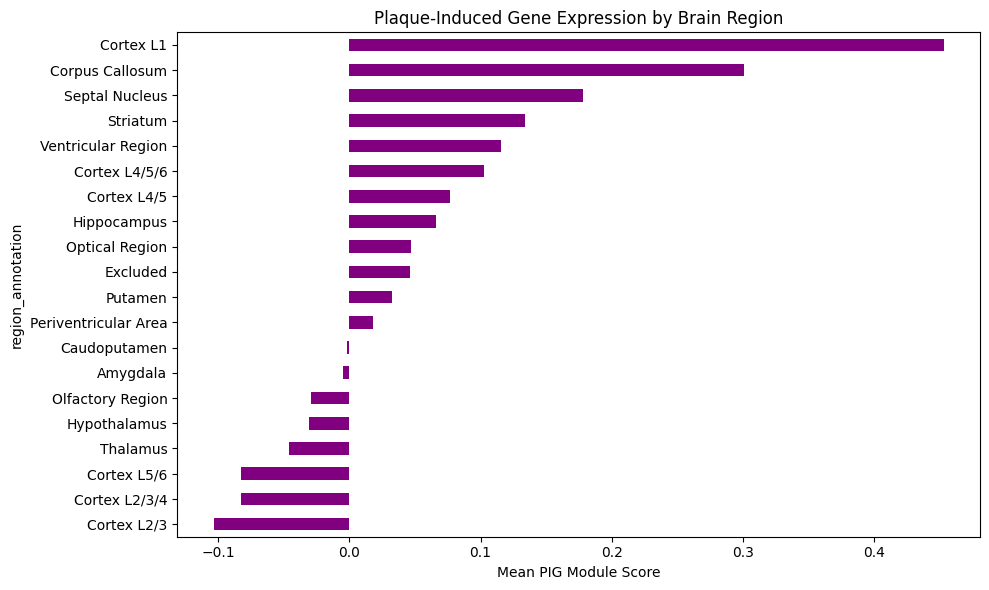

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
region_scores.plot(kind="barh", color="purple")
plt.xlabel("Mean PIG Module Score")
plt.title("Plaque-Induced Gene Expression by Brain Region")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
group = "PBS"  # or "PBS"
ad_sub = ad[ad.obs["treatment"] == group].copy()

In [9]:
sc.tl.rank_genes_groups(
    ad_sub,
    groupby="region_annotation",
    method="t-test_overestim_var"
)

In [10]:
region_de_df = sc.get.rank_genes_groups_df(ad_sub, group=None)  # returns all groups

In [11]:
def volcano_plot_region_within_group(adata, region, logfc_thresh=1, padj_thresh=0.05, top_n=10):
    de = sc.get.rank_genes_groups_df(adata, group=region)
    de = de.replace([np.inf, -np.inf], np.nan).dropna(subset=['logfoldchanges', 'pvals_adj'])
    de['-log10(padj)'] = -np.log10(de['pvals_adj'])

    plt.figure(figsize=(10, 6))
    plt.scatter(de['logfoldchanges'], de['-log10(padj)'], c='lightgrey', alpha=0.7)

    sig = (de['pvals_adj'] < padj_thresh) & (np.abs(de['logfoldchanges']) > logfc_thresh)
    plt.scatter(
        de.loc[sig, 'logfoldchanges'],
        de.loc[sig, '-log10(padj)'],
        c='crimson'
    )

    top_genes = de.loc[sig].sort_values('-log10(padj)', ascending=False).head(top_n)
    for _, row in top_genes.iterrows():
        plt.text(
            row['logfoldchanges'],
            row['-log10(padj)'],
            row['names'],
            fontsize=8,
            ha='right' if row['logfoldchanges'] < 0 else 'left'
        )

    plt.axhline(-np.log10(padj_thresh), linestyle='--', color='gray')
    plt.axvline(-logfc_thresh, linestyle='--', color='gray')
    plt.axvline(logfc_thresh, linestyle='--', color='gray')
    plt.xlabel("log2 fold change (region vs rest)")
    plt.ylabel("-log10 adjusted p-value")
    plt.title(f"Volcano plot — Region: {region} (within {adata.obs['treatment'][0]})")
    plt.tight_layout()
    plt.show()

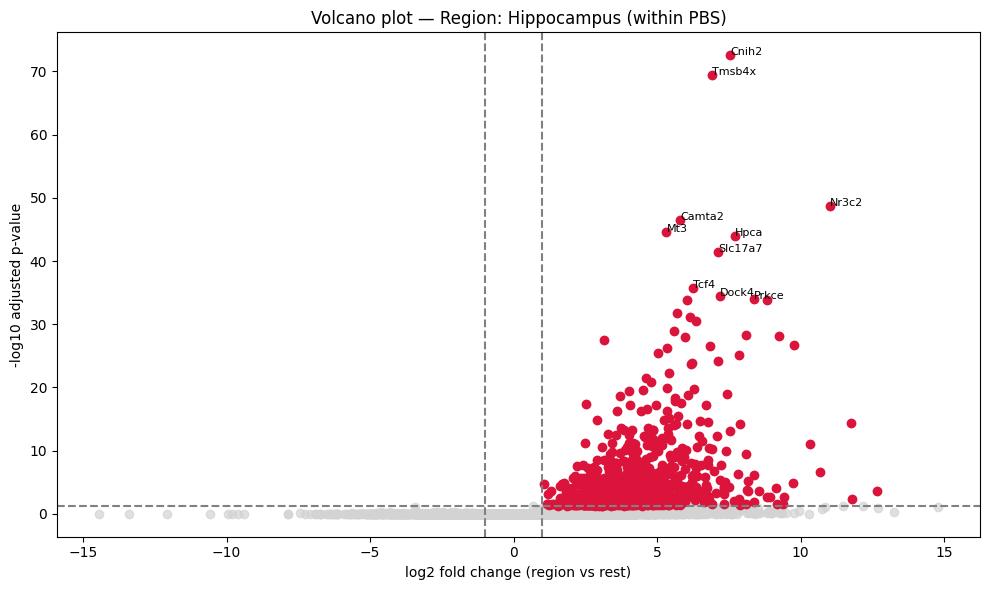

In [12]:
volcano_plot_region_within_group(ad_sub, region="Hippocampus")

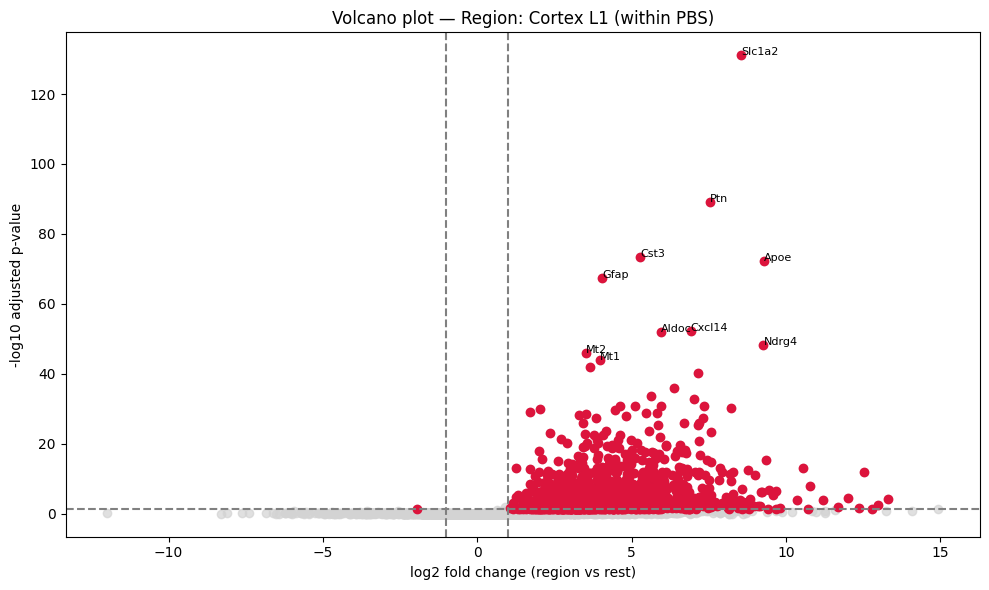

In [13]:
volcano_plot_region_within_group(ad_sub, region="Cortex L1")

In [32]:
# Filter PBS samples with region annotations
ad_pbs = ad[(ad.obs["treatment"] == "PBS") & (ad.obs["region_annotation"].notna())].copy()

# Plot dotplot of PIG genes across regions
sc.pl.dotplot(
    ad_pbs,
    var_names=pig_genes,
    groupby="region_annotation",
    standard_scale='var',  # optional: normalize each gene across groups
    dendrogram=True,
    figsize=(12, 6),
    show=True
)

KeyError: "Could not find keys '['C4a', 'Cd63-ps', 'Gpx4', 'RP23-269H21.1', 'Rpl18a']' in columns of `adata.obs` or in adata.var_names."

✅ Scored PIG module with 26 genes
✅ Scored OLIG module with 14 genes


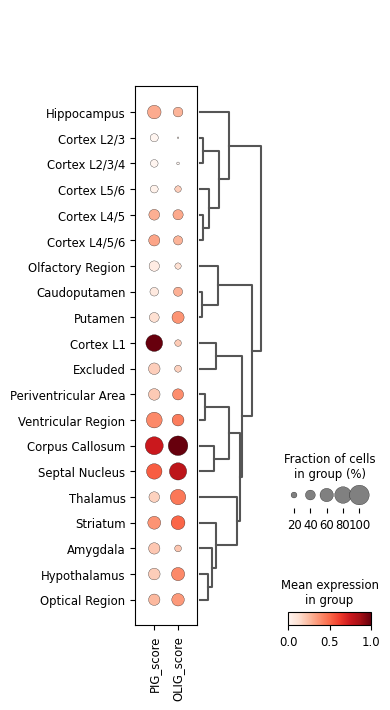

In [17]:

score_and_plot_modules(ad_sub, modules, groupby="region_annotation")

✅ Scored PIG module with 26 genes
✅ Scored OLIG module with 14 genes


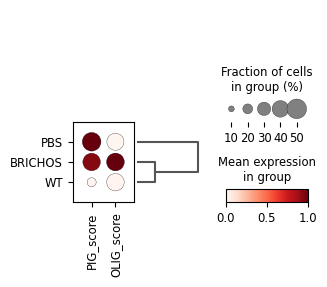

In [18]:
modules = {
    "PIG": pig_genes,
    "OLIG": olig_genes
}
score_and_plot_modules(ad, modules, groupby="treatment")

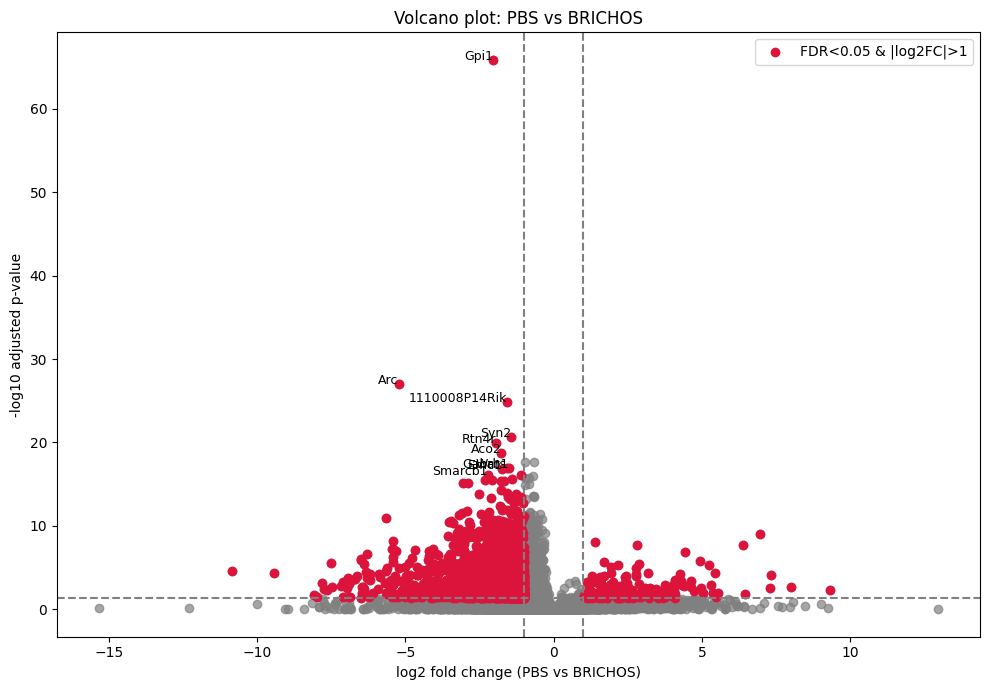

In [26]:
ad_sub = ad[ad.obs.region_annotation == 'Cortex L1']
volcano_plot_br(ad_sub, groupby='treatment',
    group1='PBS',
    group2='BRICHOS')

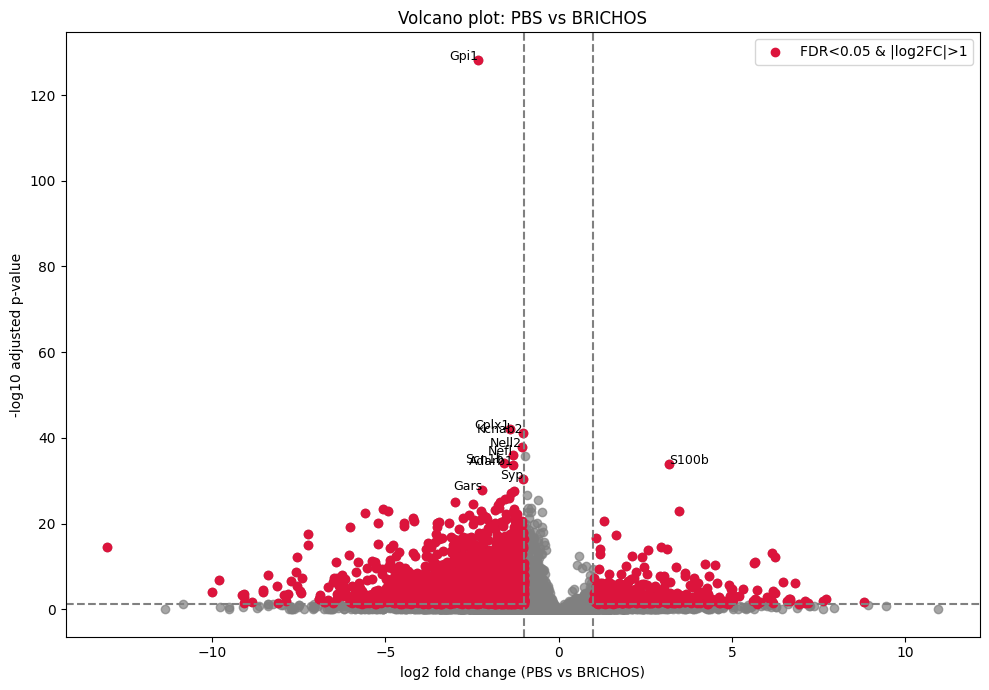

In [27]:
ad_sub = ad[ad.obs.region_annotation == 'Corpus Callosum']
volcano_plot_br(ad_sub, groupby='treatment',
    group1='PBS',
    group2='BRICHOS')